In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#**Import Libraries**

In [13]:
# =====================================================
# prepare.ipynb
# =====================================================

import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# **Function to Load Data**

In [14]:
# -----------------------------
# Load SMS Spam Dataset
# -----------------------------
def load_data(file_path: str) -> pd.DataFrame:
    """
    Load SMS spam dataset from a tab-separated file.
    Format:
    label <tab> message
    """
    df = pd.read_csv(
        file_path,
        sep="\t",
        header=None,
        names=["label", "message"],
        encoding="latin-1"
    )
    df = df.dropna().reset_index(drop=True)
    return df

# **Exploratory Data Analysis**

This code performs initial exploration of the SMS Spam dataset to understand its structure and class distribution

The dataset is loaded into a DataFrame using a custom load_data() function.

df.shape is used to verify the number of rows (messages) and columns (features).

value_counts() on the label column shows how many messages are spam vs ham, helping detect class imbalance.

value_counts(normalize=True) shows the percentage distribution of each class, which is important for choosing evaluation metrics.

df.sample() displays random messages to manually inspect data quality and message patterns.

In [16]:
# -----------------------------
# Basic Exploratory Data Analysis (EDA)
# -----------------------------
df = load_data("/content/drive/MyDrive/AMLAssignment/Assignment_1/SmSSpamCollection")

print("Dataset shape:", df.shape)

print("\nClass distribution:")
print(df["label"].value_counts())
print("\nClass proportions:")
print(df["label"].value_counts(normalize=True))
print("\nSample messages:")
print(df.sample(3, random_state=42))



Dataset shape: (5572, 2)

Class distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

Class proportions:
label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

Sample messages:
     label                                            message
3245   ham  Squeeeeeze!! This is christmas hug.. If u lik ...
944    ham  And also I've sorta blown him off a couple tim...
1044   ham  Mmm thats better now i got a roast down me! iÂ...


# **Class Distribution Plot**

This code visualizes the distribution of ham vs spam messages using a bar chart

value_counts() calculates how many messages belong to each class

A bar plot is created to visually compare the number of ham and spam messages

The plot includes:

&nbsp;&nbsp;&nbsp;Title for context

&nbsp;&nbsp;&nbsp;X-axis label showing class meaning

&nbsp;&nbsp;&nbsp;Y-axis showing message count

rotation=0 keeps class labels horizontal for readability.

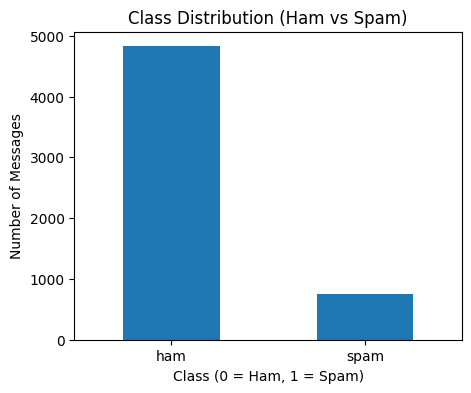

In [17]:


# -----------------------------
# Class Distribution Plot
# -----------------------------
class_counts = df["label"].value_counts()

plt.figure(figsize=(5, 4))
class_counts.plot(kind="bar")
plt.title("Class Distribution (Ham vs Spam)")
plt.xlabel("Class (0 = Ham, 1 = Spam)")
plt.ylabel("Number of Messages")
plt.xticks(rotation=0)
plt.show()


# **Message Length Distribution**

This code analyzes and visualizes the distribution of SMS message lengths.

A new column msg_length is created by calculating the number of characters in each message using len().

A histogram is plotted to show how message lengths are distributed across the dataset.

The plot includes:

&nbsp;&nbsp;&nbsp;Title describing what is being visualized

&nbsp;&nbsp;&nbsp;X-axis showing message length in characters

&nbsp;&nbsp;&nbsp;Y-axis showing how frequently each length range appears

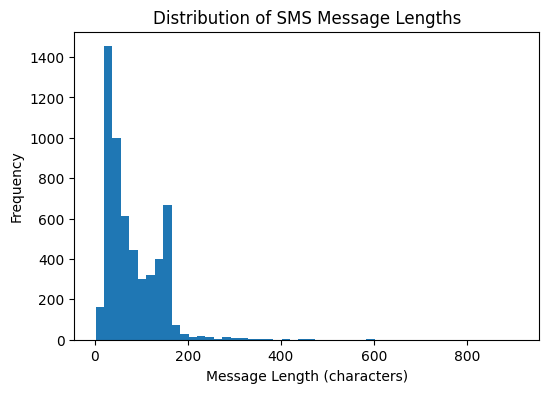

In [18]:
# -----------------------------
# Message Length Distribution
# -----------------------------
df["msg_length"] = df["message"].apply(len)

plt.figure(figsize=(6, 4))
plt.hist(df["msg_length"], bins=50)
plt.title("Distribution of SMS Message Lengths")
plt.xlabel("Message Length (characters)")
plt.ylabel("Frequency")
plt.show()


# **Text Preprocessing**

This code cleans SMS text data and converts labels into numerical format for machine learning.

preprocess_text() cleans each message by:

&nbsp;&nbsp;&nbsp;Converting text to lowercase to maintain consistency.

&nbsp;&nbsp;&nbsp;Removing special characters and punctuation using regex.

&nbsp;&nbsp;&nbsp;Removing extra spaces to standardize text formatting.

preprocess_data() applies preprocessing to the full dataset:

&nbsp;&nbsp;&nbsp;Creates a copy of the DataFrame to avoid modifying the original data.

&nbsp;&nbsp;&nbsp;Cleans all messages using preprocess_text().

&nbsp;&nbsp;&nbsp;Converts labels from text (ham, spam) to numeric format (0, 1) for model training.

In [20]:

# -----------------------------
# Text Preprocessing
# -----------------------------
def preprocess_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["message"] = df["message"].apply(preprocess_text)
    df["label"] = df["label"].map({"ham": 0, "spam": 1})
    return df

# **Inspect Preprocessed Text**

This code compares original SMS messages with their preprocessed versions to verify that text cleaning is working correctly.

&nbsp;&nbsp;&nbsp;A small random sample of 5 messages is selected using sample() for quick inspection.

&nbsp;&nbsp;&nbsp;Only relevant columns (message, label) are kept for clarity.

&nbsp;&nbsp;&nbsp;A new column preprocessed_message is created by applying the preprocessing function.

&nbsp;&nbsp;&nbsp;display() shows the comparison in a table format for easy visual verification.

In [21]:
# -----------------------------
# Inspect Preprocessed Text
# -----------------------------
print("\nSample comparison of original vs preprocessed text:\n")

sample_df = df.sample(5, random_state=42)[["message", "label"]].copy()
sample_df["preprocessed_message"] = sample_df["message"].apply(preprocess_text)

display(sample_df)



Sample comparison of original vs preprocessed text:



,message,label,preprocessed_message
3245,Squeeeeeze!! This is christmas hug.. If u lik ...,ham,squeeeeeze this is christmas hug if u lik my f...
944,And also I've sorta blown him off a couple tim...,ham,and also i ve sorta blown him off a couple tim...
1044,Mmm thats better now i got a roast down me! iÂ...,ham,mmm thats better now i got a roast down me i d...
2484,Mm have some kanji dont eat anything heavy ok,ham,mm have some kanji dont eat anything heavy ok
812,So there's a ring that comes with the guys cos...,ham,so there s a ring that comes with the guys cos...


# **Data Split into Train, Test and Validation**

This code splits the dataset into training, validation, and test sets for proper machine learning evaluation.

The function ensures split ratios sum to 1 using an assertion check.

First split:

&nbsp;&nbsp;Separates training data (70%) from remaining data (30%).

Second split:

&nbsp;&nbsp;Divides remaining data into validation (15%) and test (15%).

stratify=df["label"] ensures class distribution (ham/spam ratio) remains similar in all splits.

random_state ensures reproducible splits across runs.

In [22]:
# -----------------------------
# Train / Validation / Test Split
# -----------------------------
def split_data(
    df: pd.DataFrame,
    train_size=0.7,
    val_size=0.15,
    test_size=0.15,
    random_state=42
):
    assert train_size + val_size + test_size == 1.0

    train_df, temp_df = train_test_split(
        df,
        test_size=(1 - train_size),
        stratify=df["label"],
        random_state=random_state
    )

    val_df, test_df = train_test_split(
        temp_df,
        test_size=(test_size / (val_size + test_size)),
        stratify=temp_df["label"],
        random_state=random_state
    )

    return train_df, val_df, test_df

# **Save Splits**

This code saves the training, validation, and test datasets as separate CSV files for later use.

The function takes the three split DataFrames and an optional output directory.

to_csv() is used to save each dataset into a separate file:

&nbsp;&nbsp;&nbsp;train.csv → Training data

&nbsp;&nbsp;&nbsp;validation.csv → Validation data

&nbsp;&nbsp;&nbsp;test.csv → Test data

index=False ensures row index numbers are not saved in the CSV files.

In [23]:
# -----------------------------
# Save Splits
# -----------------------------
def save_splits(train_df, val_df, test_df, output_dir="."):
    train_df.to_csv(f"{output_dir}/train.csv", index=False)
    val_df.to_csv(f"{output_dir}/validation.csv", index=False)
    test_df.to_csv(f"{output_dir}/test.csv", index=False)


# **Pipeline for Preparation**

This code executes the complete data preparation workflow from loading data to saving final dataset splits.

&nbsp;&nbsp;&nbsp;The script runs only when executed directly (not when imported) using if __name__ == "__main__":.

&nbsp;&nbsp;&nbsp;The dataset is loaded from the specified path using load_data().

&nbsp;&nbsp;&nbsp;Text preprocessing is applied to clean messages and convert labels to numeric format.

&nbsp;&nbsp;&nbsp;The dataset is split into training, validation, and test sets using split_data().

&nbsp;&nbsp;&nbsp;The number of samples in each split is printed for verification.

&nbsp;&nbsp;&nbsp;The split datasets are saved as CSV files in the specified output directory using save_splits().

In [24]:
# -----------------------------
# Run Preparation Pipeline
# -----------------------------
if __name__ == "__main__":
    df = load_data("/content/drive/MyDrive/AMLAssignment/Assignment_1/SmSSpamCollection")
    df = preprocess_data(df)

    train_df, val_df, test_df = split_data(df)
    print("Data preparation complete")
    print("Train:", len(train_df))
    print("Validation:", len(val_df))
    print("Test:", len(test_df))
    save_splits(train_df, val_df, test_df,output_dir="/content/drive/MyDrive/AMLAssignment/Assignment_1")
    print("\nDatasets saved as:")
    print("  - train.csv")
    print("  - validation.csv")
    print("  - test.csv")



Data preparation complete
Train: 3900
Validation: 836
Test: 836

Datasets saved as:
  - train.csv
  - validation.csv
  - test.csv
